<a href="https://colab.research.google.com/github/Papadopoulos18/CIFAR-10-with-Pytorch/blob/main/CIFAR_10_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#load the data

In [37]:
train_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
print(train_dataset.data.shape)
print(len(train_dataset.targets))   #targets are a list
print(test_dataset.data.shape)
print(len(test_dataset.data))



(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
10000


number of classes

In [39]:
K = len(set(train_dataset.targets))     #train_dataset.targets->60000x1, .numpy->array([60000x1]),set->dict{0 to 9}
print(f'Number of classes are: {K}')

Number of classes are: 10


#Data loader
useful because it automatically generates batches in the training loop and takes care of shuffling

In [40]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

the data transformer mapped the data to (0,1) \
and also **moved the color channel before the height/width**

In [41]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)

for x, y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.3059, 0.3059, 0.3294,  ..., 0.1373, 0.1255, 0.1255],
          [0.2784, 0.2784, 0.3098,  ..., 0.1412, 0.1333, 0.1333],
          [0.2784, 0.3804, 0.4510,  ..., 0.1843, 0.1608, 0.1608],
          ...,
          [0.5882, 0.5490, 0.5490,  ..., 0.3020, 0.2549, 0.2627],
          [0.4902, 0.4745, 0.4314,  ..., 0.1412, 0.1529, 0.1412],
          [0.5216, 0.4941, 0.4549,  ..., 0.1490, 0.1529, 0.1373]],

         [[0.2980, 0.2824, 0.2510,  ..., 0.0745, 0.0784, 0.0784],
          [0.2980, 0.2980, 0.2980,  ..., 0.0863, 0.1020, 0.1137],
          [0.3373, 0.4667, 0.5216,  ..., 0.1412, 0.1490, 0.1569],
          ...,
          [0.6039, 0.6039, 0.6157,  ..., 0.3333, 0.2706, 0.2745],
          [0.4431, 0.4549, 0.4196,  ..., 0.1373, 0.1333, 0.1176],
          [0.4706, 0.4510, 0.4078,  ..., 0.1137, 0.1098, 0.0902]],

         [[0.2824, 0.2549, 0.2235,  ..., 0.0745, 0.0392, 0.0392],
          [0.3569, 0.3843, 0.3490,  ..., 0.1333, 0.0980, 0.0980],
          [0.4902, 0.6784, 0.6588,  ..., 0

#Define the model

In [42]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN,self).__init__()

    # define the conv layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

    # define the linear layers
    self.fc1 = nn.Linear(128*3*3, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 128*3*3)
    x = F.dropout(x, p=0.3)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x 


# instantiate the model
model = CNN(K)

#move the model to the GPU

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

#loss and optimizer

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#Training
a function to encapsulate the training loop

In [45]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs): 
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  
  for it in range(epochs):
    tO = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradient
      optimizer.zero_grad()

      #forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - tO
    print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss: .4f}, \
    Test Loss: {test_loss: .4f}, duration: {dt}')

  return train_losses, test_losses


train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=9) 


Epoch 1/9, Train Loss:  1.6568,     Test Loss:  1.4129, duration: 0:00:14.389013
Epoch 2/9, Train Loss:  1.3507,     Test Loss:  1.2858, duration: 0:00:13.989585
Epoch 3/9, Train Loss:  1.2260,     Test Loss:  1.1923, duration: 0:00:13.932708
Epoch 4/9, Train Loss:  1.1327,     Test Loss:  1.1472, duration: 0:00:14.102943
Epoch 5/9, Train Loss:  1.0473,     Test Loss:  1.0870, duration: 0:00:14.758573
Epoch 6/9, Train Loss:  0.9829,     Test Loss:  1.0615, duration: 0:00:14.016651
Epoch 7/9, Train Loss:  0.9202,     Test Loss:  1.0632, duration: 0:00:14.101784
Epoch 8/9, Train Loss:  0.8601,     Test Loss:  1.0222, duration: 0:00:13.952028
Epoch 9/9, Train Loss:  0.8196,     Test Loss:  1.0201, duration: 0:00:13.907934


plot train loss and test loss per iteration


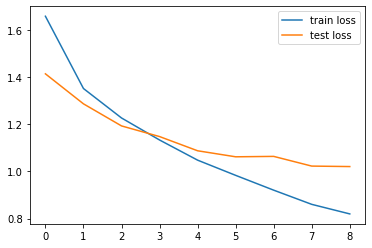

In [46]:
plt.plot(train_losses, label= 'train loss')
plt.plot(test_losses, label= 'test loss')
plt.legend()
plt.show()


# Accuracy

In [48]:
n_correct = 0.
n_total = 0.
i=0

for inputs, targets in train_loader:
  i+=1
  # move the data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  if ( i==1):
    print(inputs.shape)
  # forward pass
  outputs = model(inputs)

  # get predictions
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total
# print("for ", i)
# print(inputs.shape)
# print(f'------{predictions.shape}--{outputs.shape}----{targets.shape}')
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f'Train acc: {train_acc: .4f}, Test acc: {test_acc: .4f}')


torch.Size([128, 3, 32, 32])
Train acc:  0.7393, Test acc:  0.6437


#Confusion Matrix

Confusion Matrix without normalization
[[672  20  68  38  16  11  14  11 104  46]
 [ 27 742  15  14  11   7   7   4  33 140]
 [ 56   5 495  93 132  82  84  23  16  14]
 [ 16   8  76 489  81 213  60  23  11  23]
 [ 27   8  90  86 557  55  84  71  17   5]
 [ 13   5  56 186  61 601  34  31   5   8]
 [  9   3  30  65  68  57 740   9   5  14]
 [ 20   2  34  69  78 103  17 647   2  28]
 [ 73  50  25  20   9  16   9   1 769  28]
 [ 32 101  14  25   6  16  16  17  38 735]]


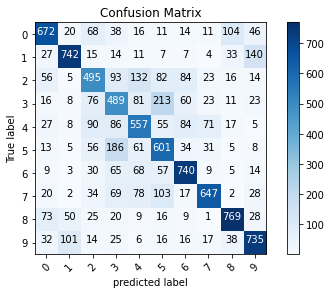

In [50]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  
  # This function prints and plots the confusion matrix.
  # Normalization can be applied by setting 'normalize=True'

  if normalize:
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
    print('Normalize confusion Matrix')
  else:
    print('Confusion Matrix without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
    
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')
  plt.show()


# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
 
for inputs, targets in test_loader:
  # move date to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # Get predictions
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [51]:
# label mapping 
labels = '''airplane,
Automobile,
bird,
Cat,
Deer,
dog,
frog,
horse,
Ship,
Truck'''.split("\n")


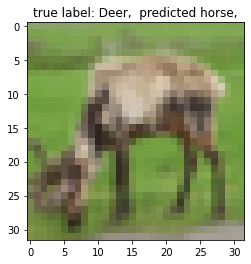

In [59]:
# show some misclassified examples

p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("true label: %s  predicted %s" % (labels[y_test[i]], labels[p_test[i]]));